# Test Full Code with Birmingham
### Gavin Rolls

This notebook will be a compilation of the methods I've applied to London as my area of study and attempt to recreate the model in Birmingham

# Data Collection

### Imports + Database Configuration

In [144]:
#Library Imports - using DuckDB for Overture Import

#Database
import duckdb

#Basics
import pandas as pd
import geopandas as gpd
import numpy as np
from geopy.geocoders import Nominatim

#OpenStreetMap
import osmnx as ox

#Shapely
from geopy.geocoders import Nominatim
from shapely.geometry import box
from shapely import wkt
import shapely.geometry
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Warning Supression
import warnings

#Machine Learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import ast

#ML from mljar-supervised
from supervised.automl import AutoML

#Warning Supression
import warnings

In [3]:
#Config SQL
%pip install ipython-sql duckdb duckdb-engine jupysql --quiet
%pip install --upgrade grpcio --quiet
%load_ext sql

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

In [6]:
%%sql      
INSTALL httpfs;

LOAD httpfs;

INSTALL spatial;

LOAD spatial;

SET s3_region='us-west-2';

,Success


### Download Buildings - Overture

Downloaded as 'data/bham_buildings_overture.geojson'

In [12]:
#Get Birmingham Bounding Box

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapi")

# Get location data
location = geolocator.geocode("Birmingham")

# Get the bounding box
bounding_box = location.raw['boundingbox']

# Convert bounding box to coordinates
min_lat, max_lat = float(bounding_box[0]), float(bounding_box[1])
min_lon, max_lon = float(bounding_box[2]), float(bounding_box[3])

print(min_lon)
print(min_lat)
print(max_lon)
print(max_lat)

-2.0336486
52.381053
-1.7288417
52.6087058


In [14]:
%%sql

LOAD azure;

SET azure_storage_connection_string = 'DefaultEndpointsProtocol=https;AccountName=overturemapswestus2;AccountKey=;EndpointSuffix=core.windows.net';
COPY (
SELECT
    names.primary as primary_name,
    height,
    level,
    ST_GeomFromWKB(geometry) as geometry
FROM read_parquet('azure://release/2024-05-16-beta.0/theme=buildings/type=building/*', filename=true, hive_partitioning=1)
WHERE primary_name IS NOT NULL
AND bbox.xmin > -2.0336486
AND bbox.xmax < -1.7288417
AND bbox.ymin > 52.381053
AND bbox.ymax < 52.6087058
) TO 'data/overture_data/bham_buildings_overture.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


### Download POIs - Overture

Downloaded as 'data/bham_places_overture.geojson''

In [15]:
%%sql

COPY (
    SELECT
        names.primary AS name,
        categories.main as category,
        ROUND(confidence,2) as confidence,
        ST_GeomFromWKB(geometry) as geometry
FROM read_parquet('s3://overturemaps-us-west-2/release/2024-05-16-beta.0/theme=places/*/*')
WHERE
    bbox.xmin BETWEEN -2.0336486 AND -1.7288417 AND
    bbox.ymin BETWEEN 52.381053 AND 52.6087058
) TO 'data/overture_data/bham_places_overture.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


### Overture Download Stats

In [35]:
#Basic overview stats of Birmingham Data - Using the locally saved files here
buildings = gpd.read_file('data/overture_data/bham_buildings_overture.geojson')
places = gpd.read_file('data/overture_data/bham_places_overture.geojson')

#Count of Features
print("Birmingham Building Count: " + str(buildings.shape[0]))
print("Birmingham POI count: " + str(places.shape[0]))

Birmingham Building Count: 11987
Birmingham POI count: 46781


### Download Buildings - OSM

Downloaded as 'data/osmbuildings/building_footprints.geojson'

In [36]:
#Download Data for Birmingham
place_name = 'Birmingham, United Kingdom'

#Test new config
ox.config(use_cache=True, log_console=True)

buildings = ox.features_from_place(place_name, tags={'building': True})
buildings = buildings[buildings.geometry.notnull()]
building_footprints = buildings[buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in building_footprints.columns:
    if building_footprints.apply(lambda x: isinstance(x, list)).any():
        building_footprints = building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

building_footprints = building_footprints[['name', 'geometry']].reset_index()
print(building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
building_footprints.to_file("data/osm_data/bham_buildings.geojson", driver="GeoJSON")

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_92764/2788206819.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


       element_type     osmid                                          name  \
0               way  16966777                                           NaN   
1               way  16966784                                           NaN   
2               way  16966785                                           NaN   
3               way  16966788                                           NaN   
4               way  16966789                                           NaN   
...             ...       ...                                           ...   
256261     relation  15607352                   Beauchamp Convenience Store   
256262     relation  15809922                                       Block A   
256263     relation  15823526                                           NaN   
256264     relation  16414329  Birmingham Settlement - 610 Community Centre   
256265     relation  16542773                                           NaN   

                                                 ge

### Extract Building Type Info from OSM - Commercial

In [37]:
#Download Data for Birmingham
place_name = 'Birmingham, United Kingdom'

commercial_buildings = ox.features_from_place(place_name, tags={'building': ['commercial']})

commercial_buildings = commercial_buildings[commercial_buildings.geometry.notnull()]
commercial_building_footprints = commercial_buildings[commercial_buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in commercial_building_footprints.columns:
    if commercial_building_footprints.apply(lambda x: isinstance(x, list)).any():
        commercial_building_footprints = commercial_building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

commercial_building_footprints = commercial_building_footprints[['name', 'geometry']].reset_index()
print(commercial_building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
commercial_building_footprints.to_file("data/osm_data/bham_commercial_buildings.geojson", driver="GeoJSON")

    element_type       osmid                     name  \
0            way    17405658                      NaN   
1            way    20002347  Dental Care Partnership   
2            way    22763584            Station House   
3            way    22763760                      NaN   
4            way    22763952                      NaN   
..           ...         ...                      ...   
312          way  1259115143                      NaN   
313          way  1259115144                      NaN   
314          way  1259115145                      NaN   
315     relation      333915      The Custard Factory   
316     relation     7076030                Eagle Two   

                                              geometry  
0    POLYGON ((-1.82146 52.56186, -1.82179 52.56209...  
1    POLYGON ((-1.82680 52.55679, -1.82680 52.55680...  
2    POLYGON ((-1.82027 52.56533, -1.82036 52.56528...  
3    POLYGON ((-1.81624 52.56247, -1.81633 52.56237...  
4    POLYGON ((-1.82061 52.565

### Extract Building Type Info from OSM - Office

In [39]:
#Download Data for Birmingham
place_name = 'Birmingham, United Kingdom'

ox.config(use_cache=True, log_console=True)

office_buildings = ox.features_from_place(place_name, tags={'building': ['office']})

office_buildings = office_buildings[office_buildings.geometry.notnull()]
office_building_footprints = office_buildings[office_buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in office_building_footprints.columns:
    if office_building_footprints.apply(lambda x: isinstance(x, list)).any():
        office_building_footprints[col] = office_building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

office_building_footprints = office_building_footprints[['name', 'geometry']].reset_index()
print(office_building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
office_building_footprints.to_file("data/osm_data/bham_office_buildings.geojson", driver="GeoJSON")


    element_type     osmid                     name  \
0            way  22820818        Baskerville House   
1            way  28292471     No. 1 Colmore Square   
2            way  28425056         McLaren Building   
3            way  28455010        Gazette Buildings   
4            way  28514237                      NaN   
..           ...       ...                      ...   
190     relation   1298933           Fountain Court   
191     relation   3417218     Eight Brindley Place   
192     relation   3417219     Seven Brindley Place   
193     relation   3417220       Ten Brindley Place   
194     relation   4631334  Birmingham Royal Ballet   

                                              geometry  
0    POLYGON ((-1.90809 52.48018, -1.90735 52.48039...  
1    POLYGON ((-1.89668 52.48235, -1.89675 52.48258...  
2    POLYGON ((-1.89265 52.48192, -1.89247 52.48183...  
3    POLYGON ((-1.89313 52.48261, -1.89339 52.48236...  
4    POLYGON ((-1.90172 52.47568, -1.90125 52.47528...

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_92764/2941556620.py:4: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


### Extract Building Type Info from OSM - Residential

In [40]:
#Download Data for Birmingham
place_name = 'Birmingham, United Kingdom'

ox.config(use_cache=True, log_console=True)

residential_buildings = ox.features_from_place(place_name, tags={'building': ['residential']})

residential_buildings = residential_buildings[residential_buildings.geometry.notnull()]
residential_building_footprints = residential_buildings[residential_buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in residential_building_footprints.columns:
    if residential_building_footprints.apply(lambda x: isinstance(x, list)).any():
        residential_building_footprints[col] = residential_building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

residential_building_footprints = residential_building_footprints[['name', 'geometry']].reset_index()
print(residential_building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
residential_building_footprints.to_file("data/osm_data/bham_residential_buildings.geojson", driver="GeoJSON")


/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_92764/2012114761.py:4: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


       element_type     osmid           name  \
0               way  16966777            NaN   
1               way  16966784            NaN   
2               way  16966785            NaN   
3               way  16966788            NaN   
4               way  16966789            NaN   
...             ...       ...            ...   
189381     relation  10407216            NaN   
189382     relation  11382596  Bentley House   
189383     relation  12197160            NaN   
189384     relation  15809922        Block A   
189385     relation  16542773            NaN   

                                                 geometry  
0       POLYGON ((-1.82461 52.55549, -1.82450 52.55543...  
1       POLYGON ((-1.82324 52.55438, -1.82301 52.55434...  
2       POLYGON ((-1.82273 52.55403, -1.82264 52.55400...  
3       POLYGON ((-1.82341 52.55414, -1.82338 52.55412...  
4       POLYGON ((-1.82311 52.55396, -1.82302 52.55391...  
...                                                   ...  
189

### Extract Building Type Info from OSM - Retail

In [41]:
#Download Data for Birmingham
place_name = 'Birmingham, United Kingdom'

ox.config(use_cache=True, log_console=True)

retail_buildings = ox.features_from_place(place_name, tags={'building': ['retail']})

retail_buildings = retail_buildings[retail_buildings.geometry.notnull()]
retail_building_footprints = retail_buildings[retail_buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in retail_building_footprints.columns:
    if retail_building_footprints.apply(lambda x: isinstance(x, list)).any():
        retail_building_footprints[col] = retail_building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

retail_building_footprints = retail_building_footprints[['name', 'geometry']].reset_index()
print(retail_building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
retail_building_footprints.to_file("data/osm_data/bham_retail_buildings.geojson", driver="GeoJSON")


/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_92764/291704794.py:4: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


     element_type     osmid                         name  \
0             way  16969083                        Boots   
1             way  17273169                          NaN   
2             way  20002348                  Vesey Manor   
3             way  20002352             Driffold Gallery   
4             way  23585174                     One Stop   
...           ...       ...                          ...   
3499     relation   2912290                  Sainsbury's   
3500     relation   5536524                Grand Central   
3501     relation  10748407             Picadilly Arcade   
3502     relation  14397641                          NaN   
3503     relation  15607352  Beauchamp Convenience Store   

                                               geometry  
0     POLYGON ((-1.82369 52.55768, -1.82379 52.55771...  
1     POLYGON ((-1.89325 52.47748, -1.89313 52.47745...  
2     POLYGON ((-1.82665 52.55648, -1.82665 52.55630...  
3     POLYGON ((-1.82722 52.55565, -1.82734 52.

# Data Cleaning
### Taken from v2

## Data Loading + Cleaning

### UK BRES Employment Data

In [53]:
#Skip the first six rows because they're header information
empl_data = pd.read_csv('data/employment_data/lsoa_by_industry.csv', skiprows=7, delimiter=',')

unnamed_cols = empl_data.columns[empl_data.columns.str.contains('^Unnamed:')]
empl_data.drop(columns=unnamed_cols, inplace=True)

#Separate name into LSOA11CD and LSOA11NM
def split_column(value):
    if isinstance(value, str) and 'lsoa2011:' in value:
        parts = value.split('lsoa2011:')[1]
        code, name = parts.split(' : ')
        return code.strip(), name.strip()
    else:
        return None, None

empl_data[['LSOA11CD', 'LSOA11NM']] = empl_data['Area'].apply(lambda x: pd.Series(split_column(x)))

# Drop rows not in Birmingham
empl_data.dropna(subset=['LSOA11NM'], inplace=True)
empl_data = empl_data[empl_data['LSOA11NM'].str.contains('Birmingham')]

print("Num Rows (LSOAs) Before Cleaning: " + str(empl_data.shape[0]))

#There appear to be a bunch of duplicates so I'm going to get rid of them now
empl_data.drop_duplicates(inplace=True)

print("Num Rows (LSOAs) After Cleaning: " + str(empl_data.shape[0]))

Num Rows (LSOAs) Before Cleaning: 639
Num Rows (LSOAs) After Cleaning: 639


In [55]:
#Create Total Employment Column
empl_data['total_employment'] = empl_data[empl_data.columns[1:-2]].sum(axis=1)

empl_data.head()

,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,08 : Other mining and quarrying,09 : Mining support service activities,10 : Manufacture of food products,...,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11CD,LSOA11NM,total_employment
13485,lsoa2011:E01008881 : Birmingham 067A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,E01008881,Birmingham 067A,455.0
13486,lsoa2011:E01008882 : Birmingham 066A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,E01008882,Birmingham 066A,30.0
13487,lsoa2011:E01008883 : Birmingham 078A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,E01008883,Birmingham 078A,1810.0
13488,lsoa2011:E01008884 : Birmingham 078B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,...,0.0,0.0,5.0,40.0,0.0,0.0,0.0,E01008884,Birmingham 078B,2590.0
13489,lsoa2011:E01008885 : Birmingham 076A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15.0,0.0,0.0,0.0,E01008885,Birmingham 076A,90.0


### LSOA Geographic Data

In [100]:
#Get LSOA Shapefile Data
lsoa_geo = gpd.read_file('data/lsoa_data/LSOA_2011_EW_BFE_V3.shp')

#Convert to WGS for consistency
lsoa_geo = lsoa_geo.to_crs(epsg=4326)

print("Num Rows (LSOAs): " + str(lsoa_geo.shape[0]))

#Get rid of columns I'm not using for now
lsoa_geo = lsoa_geo.drop(columns=['BNG_E', 'BNG_N', 'LONG_', 'LAT', 'GlobalID', 'Shape_Leng'])

#Join with population
lsoa_pop = pd.read_csv('data/lsoa_data/lsoa_pop.csv')

lsoa_geo.drop(columns=['LSOA11NM'])

#Get population estimates - had to be pulled in from separate Census dataset
lsoa_geo = lsoa_geo.merge(lsoa_pop, on='LSOA11CD')

lsoa_geo.head()

Num Rows (LSOAs): 34753


,LSOA11CD,LSOA11NM_x,geometry,LSOA11NM_y,Unnamed: 2,population
0,E01000034,Barking and Dagenham 003A,"POLYGON ((0.17380 51.56013, 0.17379 51.56012, ...",Barking and Dagenham 003A,NaN,"1,444"
1,E01000035,Barking and Dagenham 010A,"POLYGON ((0.16598 51.55250, 0.16601 51.55248, ...",Barking and Dagenham 010A,NaN,"1,610"
2,E01000036,Barking and Dagenham 010B,"POLYGON ((0.15965 51.54776, 0.15974 51.54771, ...",Barking and Dagenham 010B,NaN,"1,353"
3,E01000037,Barking and Dagenham 003B,"POLYGON ((0.18508 51.56480, 0.18476 51.56454, ...",Barking and Dagenham 003B,NaN,"1,688"
4,E01000038,Barking and Dagenham 003C,"POLYGON ((0.17599 51.56476, 0.17601 51.56475, ...",Barking and Dagenham 003C,NaN,"1,447"


### Overture Places Data

In [58]:
overture_places = gpd.read_file('data/overture_data/bham_places_overture.geojson')

print('Number of POIs in Overture (Birmingham): ' + str(overture_places.shape[0]))
overture_places.head()

Number of POIs in Overture (Birmingham): 46781


,name,category,confidence,geometry
0,Beacon Hill Toposcope,landmark_and_historical_building,0.96,POINT (-2.01965 52.38213)
1,Lickey Hills Country Park - Beacon Hill,park,0.67,POINT (-2.01972 52.38229)
2,Lickey Monument,monument,0.55,POINT (-2.01956 52.38227)
3,Beacon Castle,park,0.67,POINT (-2.01961 52.38234)
4,Barnett Fair Unisex Hairdressing,beauty_salon,0.96,POINT (-2.00227 52.38278)


### OpenStreetMap Buildings Data

I will query each set of building types and then collapse the dataset down so that tags are preserved

In [59]:
osm_all_buildings = gpd.read_file('data/osm_data/bham_buildings.geojson')

print('Number of Buildings in OSM (Birmingham): ' + str(osm_all_buildings.shape[0]))
osm_all_buildings.head()

Number of Buildings in OSM (Birmingham): 256266


,element_type,osmid,name,geometry
0,way,16966777,None,"POLYGON ((-1.82461 52.55549, -1.82450 52.55543..."
1,way,16966784,None,"POLYGON ((-1.82324 52.55438, -1.82301 52.55434..."
2,way,16966785,None,"POLYGON ((-1.82273 52.55403, -1.82264 52.55400..."
3,way,16966788,None,"POLYGON ((-1.82341 52.55414, -1.82338 52.55412..."
4,way,16966789,None,"POLYGON ((-1.82311 52.55396, -1.82302 52.55391..."


In [62]:
# Commercial Buildings

osm_commercial_buildings = gpd.read_file('data/osm_data/bham_commercial_buildings.geojson')

print('Number of Commercial Buildings in OSM (Birmingham): ' + str(osm_commercial_buildings.shape[0]))
osm_commercial_buildings.head()

Number of Commercial Buildings in OSM (Birmingham): 317


,element_type,osmid,name,geometry
0,way,17405658,None,"POLYGON ((-1.82146 52.56186, -1.82179 52.56209..."
1,way,20002347,Dental Care Partnership,"POLYGON ((-1.82680 52.55679, -1.82680 52.55680..."
2,way,22763584,Station House,"POLYGON ((-1.82027 52.56533, -1.82036 52.56528..."
3,way,22763760,None,"POLYGON ((-1.81624 52.56247, -1.81633 52.56237..."
4,way,22763952,None,"POLYGON ((-1.82061 52.56543, -1.82042 52.56531..."


In [64]:
# Office Buildings

osm_office_buildings = gpd.read_file('data/osm_data/bham_office_buildings.geojson')

print('Number of Office Buildings in OSM (Birmingham): ' + str(osm_office_buildings.shape[0]))
osm_office_buildings.head()

Number of Office Buildings in OSM (Birmingham): 195


,element_type,osmid,name,geometry
0,way,22820818,Baskerville House,"POLYGON ((-1.90809 52.48018, -1.90735 52.48039..."
1,way,28292471,No. 1 Colmore Square,"POLYGON ((-1.89668 52.48235, -1.89675 52.48258..."
2,way,28425056,McLaren Building,"POLYGON ((-1.89265 52.48192, -1.89247 52.48183..."
3,way,28455010,Gazette Buildings,"POLYGON ((-1.89313 52.48261, -1.89339 52.48236..."
4,way,28514237,None,"POLYGON ((-1.90172 52.47568, -1.90125 52.47528..."


In [66]:
# Residential Buildings

osm_residential_buildings = gpd.read_file('data/osm_data/bham_residential_buildings.geojson')

print('Number of Residential Buildings in OSM (Birmingham): ' + str(osm_residential_buildings.shape[0]))
osm_residential_buildings.head()

Number of Residential Buildings in OSM (Birmingham): 189386


,element_type,osmid,name,geometry
0,way,16966777,None,"POLYGON ((-1.82461 52.55549, -1.82450 52.55543..."
1,way,16966784,None,"POLYGON ((-1.82324 52.55438, -1.82301 52.55434..."
2,way,16966785,None,"POLYGON ((-1.82273 52.55403, -1.82264 52.55400..."
3,way,16966788,None,"POLYGON ((-1.82341 52.55414, -1.82338 52.55412..."
4,way,16966789,None,"POLYGON ((-1.82311 52.55396, -1.82302 52.55391..."


In [67]:
# Retail Buildings

osm_retail_buildings = gpd.read_file('data/osm_data/bham_retail_buildings.geojson')

print('Number of Retail Buildings in OSM (Birmingham): ' + str(osm_retail_buildings.shape[0]))
osm_retail_buildings.head()

Number of Retail Buildings in OSM (Birmingham): 3504


,element_type,osmid,name,geometry
0,way,16969083,Boots,"POLYGON ((-1.82369 52.55768, -1.82379 52.55771..."
1,way,17273169,None,"POLYGON ((-1.89325 52.47748, -1.89313 52.47745..."
2,way,20002348,Vesey Manor,"POLYGON ((-1.82665 52.55648, -1.82665 52.55630..."
3,way,20002352,Driffold Gallery,"POLYGON ((-1.82722 52.55565, -1.82734 52.55554..."
4,way,23585174,One Stop,"POLYGON ((-1.90532 52.51745, -1.90573 52.51726..."


In [68]:
# Assign a building type in the main DataFrame if the osmid is found in one of the other DataFrames

# I know that office and retail buildings could have commercial or office but office and retail will overwrite commercia
# (and are thus checked after) because they're more specific

osm_all_buildings['building_type'] = 'none'

osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_commercial_buildings['osmid']), 'building_type'] = 'commercial'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_retail_buildings['osmid']), 'building_type'] = 'retail'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_office_buildings['osmid']), 'building_type'] = 'office'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_residential_buildings['osmid']), 'building_type'] = 'residential'

osm_all_buildings.head(50)

,element_type,osmid,name,geometry,building_type
0,way,16966777,None,"POLYGON ((-1.82461 52.55549, -1.82450 52.55543...",residential
1,way,16966784,None,"POLYGON ((-1.82324 52.55438, -1.82301 52.55434...",residential
2,way,16966785,None,"POLYGON ((-1.82273 52.55403, -1.82264 52.55400...",residential
3,way,16966788,None,"POLYGON ((-1.82341 52.55414, -1.82338 52.55412...",residential
4,way,16966789,None,"POLYGON ((-1.82311 52.55396, -1.82302 52.55391...",residential
5,way,16966791,None,"POLYGON ((-1.82282 52.55433, -1.82266 52.55431...",residential
6,way,16966794,Royal (Proposed),"POLYGON ((-1.82619 52.55661, -1.82611 52.55650...",none
7,way,16966799,None,"POLYGON ((-1.82425 52.55803, -1.82413 52.55804...",residential
8,way,16966800,James Preston Health Centre,"POLYGON ((-1.82348 52.55799, -1.82331 52.55823...",none
9,way,16966807,None,"POLYGON ((-1.82428 52.55791, -1.82431 52.55807...",residential


## Data Joining + Prep

### Joining LSOA Geography and Employment Data

In [103]:
#Note that total Birmingham statistics are dropped here because there's no equivalent column in lsoa_geo
empl_geog = pd.merge(lsoa_geo, empl_data, on = "LSOA11CD")

print("Num Rows (LSOAS): " + str(empl_geog.shape[0]))

empl_geog.head()

Num Rows (LSOAS): 639


,LSOA11CD,LSOA11NM_x,geometry,LSOA11NM_y,Unnamed: 2,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,...,92 : Gambling and betting activities,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11NM,total_employment
0,E01008881,Birmingham 067A,"POLYGON ((-1.80957 52.47014, -1.80953 52.47009...",Birmingham 067A,NaN,"1,599",lsoa2011:E01008881 : Birmingham 067A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,Birmingham 067A,455.0
1,E01008882,Birmingham 066A,"POLYGON ((-1.82792 52.46893, -1.82768 52.46891...",Birmingham 066A,NaN,"1,747",lsoa2011:E01008882 : Birmingham 066A,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Birmingham 066A,30.0
2,E01008883,Birmingham 078A,"POLYGON ((-1.82144 52.46633, -1.82143 52.46632...",Birmingham 078A,NaN,"1,816",lsoa2011:E01008883 : Birmingham 078A,0.0,0.0,0.0,...,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,Birmingham 078A,1810.0
3,E01008884,Birmingham 078B,"POLYGON ((-1.82576 52.46527, -1.82579 52.46516...",Birmingham 078B,NaN,"1,870",lsoa2011:E01008884 : Birmingham 078B,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,40.0,0.0,0.0,0.0,Birmingham 078B,2590.0
4,E01008885,Birmingham 076A,"POLYGON ((-1.80450 52.46160, -1.80414 52.46135...",Birmingham 076A,NaN,"1,308",lsoa2011:E01008885 : Birmingham 076A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,Birmingham 076A,90.0


### Add POI and Building Data

In [105]:
#Dealing with filter warnings for empty geometries in particular LSOAs
warnings.filterwarnings("ignore", category=FutureWarning)

#Init Columns (This was causing an error at first when I didn't put it here to begin)
empl_geog['num_buildings'] = 0
empl_geog['num_retail_buildings'] = 0
empl_geog['num_residential_buildings'] = 0
empl_geog['num_commercial_buildings'] = 0
empl_geog['num_office_buildings'] = 0

empl_geog['num_places'] = 0

empl_geog['building_poly'] = None
empl_geog['commercial_building_poly'] = None
empl_geog['retail_building_poly'] = None
empl_geog['office_building_poly'] = None
empl_geog['residential_building_poly'] = None

empl_geog['place_points'] = None
empl_geog['category_list'] = None

#Iterate through all LSOAs and grab OSM building counts and subcategories - add to empl_geog dataframe

for index, row in empl_geog.iterrows():

    #Status report
    if (index % 20 == 0):
        print(index)
    
    geom = row['geometry']
    filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)

    #All Buildings - OSM
    filtered_osm_buildings = osm_all_buildings[osm_all_buildings.geometry.intersects(filter_geom.unary_union)]

    #Get subcategories based on tags
    commercial_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'commercial']
    office_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'office']
    retail_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'retail']
    residential_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'residential']

    #Subcategories of each building
    filtered_commercial_buildings = commercial_buildings[commercial_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_office_buildings = office_buildings[office_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_retail_buildings = retail_buildings[retail_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_residential_buildings = residential_buildings[residential_buildings.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's (OSM) buildings - category separated
    combined_multipolygon = filtered_osm_buildings.geometry.unary_union
    combined_commercial_multipolygon = filtered_commercial_buildings.geometry.unary_union
    combined_office_polygon = filtered_office_buildings.geometry.unary_union
    combined_retail_polygon = filtered_retail_buildings.geometry.unary_union
    combined_residential_polygon = filtered_residential_buildings.geometry.unary_union
    
    #All Places
    filtered_places = overture_places[overture_places.geometry.intersects(filter_geom.unary_union)]

    #Multipoint of each LSOA's places
    combined_multipoint = filtered_places.geometry.unary_union
    
    #Add place category information
    category_list = filtered_places['category'].dropna().tolist()
    

    #Add back to Dataframe
    empl_geog.at[index, 'num_buildings'] = len(filtered_osm_buildings)
    
    empl_geog['num_retail_buildings'] = len(filtered_retail_buildings)
    empl_geog['num_residential_buildings'] = len(filtered_residential_buildings)
    empl_geog['num_commercial_buildings'] = len(filtered_commercial_buildings)
    empl_geog['num_office_buildings'] = len(filtered_office_buildings)
    
    empl_geog.at[index, 'num_places'] = len(filtered_places)
    
    empl_geog.at[index, 'building_poly'] = combined_multipolygon
    empl_geog.at[index, 'commercial_building_poly'] = combined_commercial_multipolygon
    empl_geog.at[index, 'retail_building_poly'] = combined_office_polygon
    empl_geog.at[index, 'office_building_poly'] = combined_retail_polygon
    empl_geog.at[index, 'residential_building_poly'] = combined_residential_polygon

    
    empl_geog.at[index, 'place_points'] = combined_multipoint
    empl_geog.at[index, 'category_list'] = category_list
    
#Check
empl_geog.head()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620


,LSOA11CD,LSOA11NM_x,geometry,LSOA11NM_y,Unnamed: 2,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,...,num_commercial_buildings,num_office_buildings,num_places,building_poly,commercial_building_poly,retail_building_poly,office_building_poly,residential_building_poly,place_points,category_list
0,E01008881,Birmingham 067A,"POLYGON ((-1.80957 52.47014, -1.80953 52.47009...",Birmingham 067A,NaN,"1,599",lsoa2011:E01008881 : Birmingham 067A,0.0,0.0,0.0,...,0,1,79,"MULTIPOLYGON (((-1.8213621 52.4666609, -1.8210...",None,None,"MULTIPOLYGON (((-1.8122732 52.4644594, -1.8121...","MULTIPOLYGON (((-1.8207928 52.467573, -1.82066...","MULTIPOINT ((-1.8208857 52.4670509), (-1.82066...","[convenience_store, pizza_restaurant, fast_foo..."
1,E01008882,Birmingham 066A,"POLYGON ((-1.82792 52.46893, -1.82768 52.46891...",Birmingham 066A,NaN,"1,747",lsoa2011:E01008882 : Birmingham 066A,0.0,0.0,0.0,...,0,1,5,"MULTIPOLYGON (((-1.8336333 52.4637367, -1.8332...",None,None,"MULTIPOLYGON (((-1.8332702 52.4634641, -1.8336...","MULTIPOLYGON (((-1.833377 52.4638622, -1.83337...","MULTIPOINT ((-1.8329422 52.4640839), (-1.83285...","[church_cathedral, home_security, school]"
2,E01008883,Birmingham 078A,"POLYGON ((-1.82144 52.46633, -1.82143 52.46632...",Birmingham 078A,NaN,"1,816",lsoa2011:E01008883 : Birmingham 078A,0.0,0.0,0.0,...,0,1,39,"MULTIPOLYGON (((-1.8286578 52.4605087, -1.8276...",None,None,"MULTIPOLYGON (((-1.825245 52.4631362, -1.82474...","MULTIPOLYGON (((-1.8270907 52.4634663, -1.8270...","MULTIPOINT ((-1.8271863 52.463742), (-1.827072...","[computer_store, professional_services, sporti..."
3,E01008884,Birmingham 078B,"POLYGON ((-1.82576 52.46527, -1.82579 52.46516...",Birmingham 078B,NaN,"1,870",lsoa2011:E01008884 : Birmingham 078B,0.0,0.0,0.0,...,0,1,173,"MULTIPOLYGON (((-1.8378055 52.4575343, -1.8380...",None,"POLYGON ((-1.8354944 52.4612255, -1.8352535 52...","MULTIPOLYGON (((-1.8394717 52.4632192, -1.8388...","MULTIPOLYGON (((-1.8377769 52.4595681, -1.8377...","MULTIPOINT ((-1.8443173 52.4598824), (-1.84310...","[car_window_tinting, powder_coating_service, l..."
4,E01008885,Birmingham 076A,"POLYGON ((-1.80450 52.46160, -1.80414 52.46135...",Birmingham 076A,NaN,"1,308",lsoa2011:E01008885 : Birmingham 076A,0.0,0.0,0.0,...,0,1,28,"MULTIPOLYGON (((-1.8092612 52.4561461, -1.8092...",None,None,"MULTIPOLYGON (((-1.8052836 52.4607015, -1.8052...","MULTIPOLYGON (((-1.8093482 52.4561539, -1.8092...","MULTIPOINT ((-1.8092852 52.4618985), (-1.80896...","[hotel, dry_cleaning, international_business_a..."


In [106]:
#Save to Dataframe on Desktop

#Convert multipolygons to WKT for export
empl_geog['building_poly'] = empl_geog['building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['commercial_building_poly'] = empl_geog['commercial_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['retail_building_poly'] = empl_geog['retail_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['office_building_poly'] = empl_geog['office_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['residential_building_poly'] = empl_geog['residential_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)

empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)

# Convert category_list to string for export
empl_geog['category_list'] = empl_geog['category_list'].apply(lambda x: str(x) if x else None)

#Export
empl_geog.to_file("data/bham_data/empl_geog.geojson", driver="GeoJSON")

In [107]:
# Set back to Geometries for use in plot

# WKT strings back to Shapely geometries
empl_geog['building_poly'] = empl_geog['building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['commercial_building_poly'] = empl_geog['commercial_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['retail_building_poly'] = empl_geog['retail_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['office_building_poly'] = empl_geog['office_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['residential_building_poly'] = empl_geog['residential_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

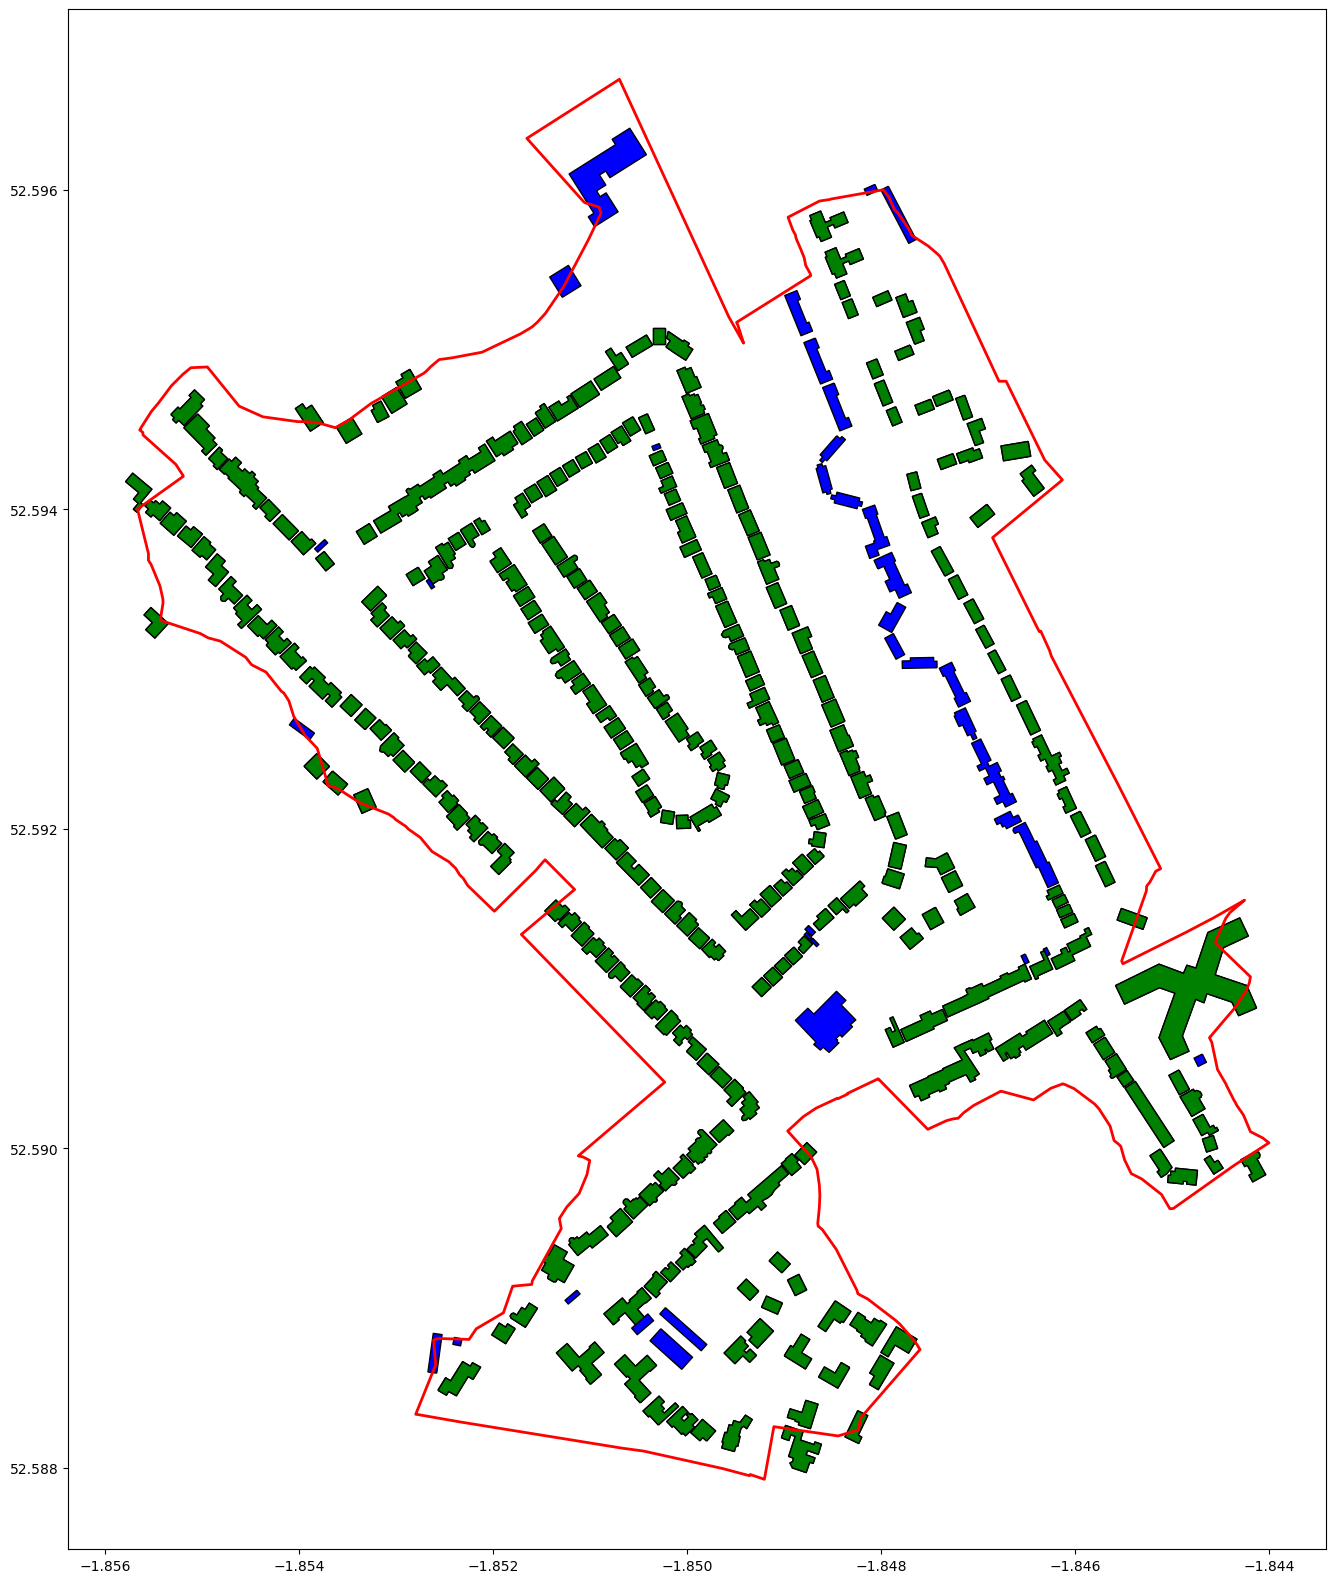

In [115]:
#Get building subset - Birmingham 059C

#Code from earlier - isolate Birmingham 059C
lsoa = empl_geog[empl_geog['LSOA11NM_x'] == 'Birmingham 001A']
geom = lsoa['geometry'].iloc[0]
filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)

#Get buildings
lsoa_all_buildings = gpd.GeoDataFrame(lsoa, geometry='building_poly')
lsoa_commercial_buildings = gpd.GeoDataFrame(lsoa, geometry='commercial_building_poly')
lsoa_office_buildings = gpd.GeoDataFrame(lsoa, geometry='office_building_poly')
lsoa_residential_buildings = gpd.GeoDataFrame(lsoa, geometry='residential_building_poly')
lsoa_retail_buildings = gpd.GeoDataFrame(lsoa, geometry='retail_building_poly')

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
lsoa_all_buildings.plot(ax=ax, color='blue', edgecolor='black')
lsoa_commercial_buildings.plot(ax=ax, color='orange', edgecolor='black')
lsoa_office_buildings.plot(ax=ax, color='red', edgecolor='black')
lsoa_residential_buildings.plot(ax=ax, color='green', edgecolor='black')
lsoa_retail_buildings.plot(ax=ax, color='purple', edgecolor='black')

filter_geom.boundary.plot(ax=ax, color='red', linewidth=2)

plt.show()

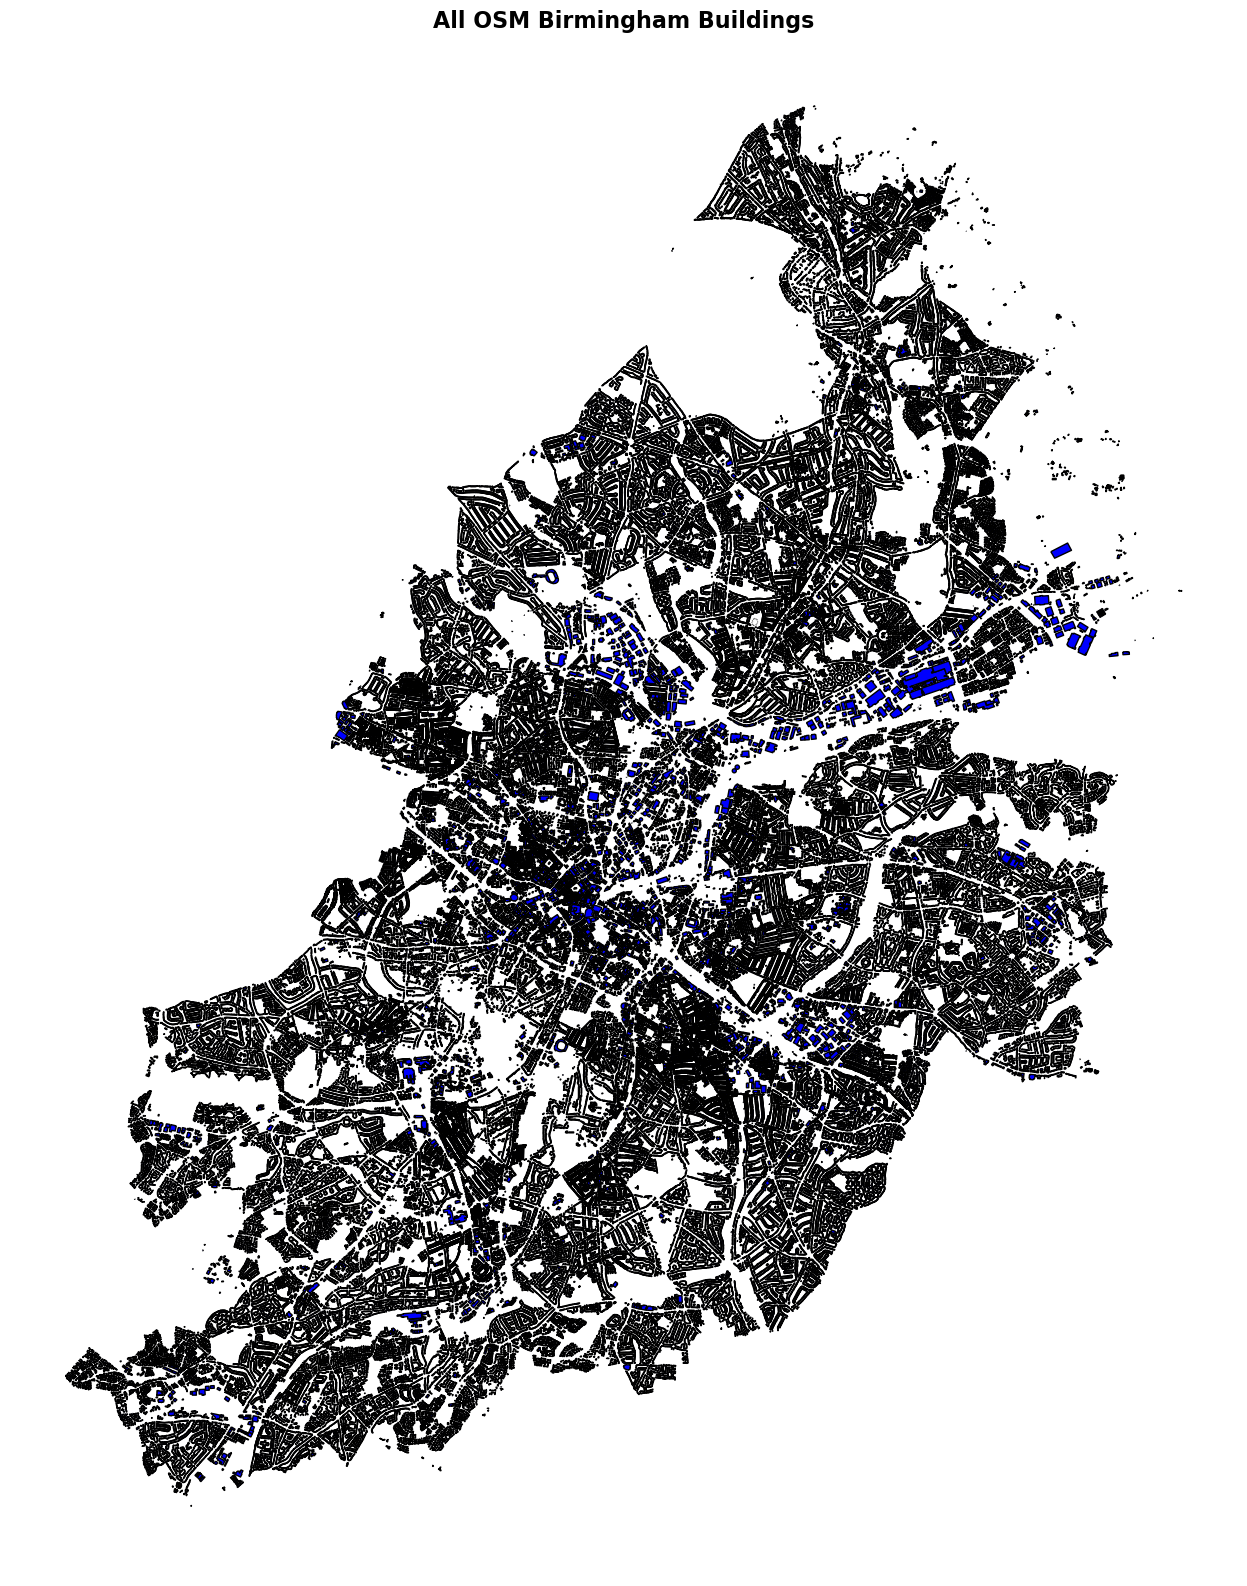

In [117]:
#Get all Birmingham

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
osm_all_buildings.plot(ax=ax, legend=True, color='blue', edgecolor='black')
ax.set_axis_off()
plt.title('All OSM Birmingham Buildings', fontsize=16, fontweight='bold')
plt.show()

# Data Exploration

### Encoding POI Categories

In [178]:
# Encode POI categories in data - using One-Hot encoding

#Make sure category list is a list
empl_geog['category_list'] = empl_geog['category_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#Explode category lists
empl_geog_exploded = empl_geog.explode('category_list')

#Set up encoder
encoder = OneHotEncoder(sparse_output=False)

#Encode
encoded_categories = encoder.fit_transform(empl_geog_exploded[['category_list']])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['category_list']))

empl_geog_exploded = pd.concat([empl_geog_exploded.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Reaggregate
empl_geog_exploded.drop(columns=['category_list'], inplace=True)

# Group by LSOA11CD - sum numeric only
numeric_columns = encoded_df.columns.tolist()
empl_geog_encoded = empl_geog_exploded.groupby('LSOA11CD')[numeric_columns].sum().reset_index()

#Store category columns
category_columns = empl_geog_encoded.columns[1:]

empl_geog_encoded.head()

,LSOA11CD,category_list_3d_printing_service,category_list_abuse_and_addiction_treatment,category_list_accommodation,category_list_accountant,category_list_active_life,category_list_acupuncture,category_list_addiction_rehabilitation_center,category_list_adoption_services,category_list_adult_education,...,category_list_windshield_installation_and_repair,category_list_wine_bar,category_list_women's_clothing_store,category_list_women's_health_clinic,category_list_wood_and_pulp,category_list_woodworking_supply_store,category_list_writing_service,category_list_yoga_studio,category_list_youth_organizations,category_list_zoo
0,E01008881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,E01008882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E01008883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,E01008884,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E01008885,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# Geometric Features Extraction (copied from earlier but includes building types now)

#I'm going to exclude num polygons, average perimeter, and total perimeter cause they're not so helpful (cause Collinearity matrix shows its very close to count)

def extract_multipolygon_features(multipolygon, lsoa_geometry):
    if isinstance(multipolygon, MultiPolygon):
        polygons = list(multipolygon.geoms)
    elif isinstance(multipolygon, Polygon):
        polygons = [multipolygon]
    else:
        return pd.Series({
            'total_area': 0,
            'avg_building_area': 0,
            'lsoa_area_ratio': 0,
        })

    num_polygons = len(polygons)
    areas = [polygon.area for polygon in polygons]
    total_area = sum(areas)
    avg_building_area = total_area / num_polygons if num_polygons > 0 else 0

    #Built-up area ratio could result in a div by zero error if there are no buildings in an LSOA so this logic has to be included here
    try:
        lsoa_area_ratio = total_area / lsoa_geometry.area
    except ZeroDivisionError:
        lsoa_area_ratio = 0

    return pd.Series({
        'total_area': total_area,
        'lsoa_area_ratio': lsoa_area_ratio,
        'avg_building_area': avg_building_area,
    })


In [150]:
# All Buildings
all_buildings_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['building_poly'], row['geometry']),
    axis=1
).add_prefix('all_')

# Residential
residential_buildings_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['residential_building_poly'], row['geometry']),
    axis=1
).add_prefix('residential_')

# Commercial
commercial_buildings_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['commercial_building_poly'], row['geometry']),
    axis=1
).add_prefix('commercial_')

# Office
office_buildings_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['office_building_poly'], row['geometry']),
    axis=1
).add_prefix('office_')

# Retail
retail_buildings_geometry_features = empl_geog.apply(
    lambda row: extract_multipolygon_features(row['retail_building_poly'], row['geometry']),
    axis=1
).add_prefix('retail_')

# Combine all geometry features into one DataFrame
all_geom_features = pd.concat([
    all_buildings_geometry_features,
    residential_buildings_geometry_features,
    commercial_buildings_geometry_features,
    office_buildings_geometry_features,
    retail_buildings_geometry_features
], axis=1, ignore_index=False)

# Capture Column Names
geo_features = all_geom_features.columns

# Display the first 50 rows
all_geom_features.head(50)

,all_total_area,all_lsoa_area_ratio,all_avg_building_area,residential_avg_building_area,residential_lsoa_area_ratio,residential_total_area,commercial_avg_building_area,commercial_lsoa_area_ratio,commercial_total_area,office_avg_building_area,office_lsoa_area_ratio,office_total_area,retail_avg_building_area,retail_lsoa_area_ratio,retail_total_area
0,0.000006,0.122619,3.285543e-08,2.302835e-08,0.063581,0.000003,0.000000e+00,0.000000,0.000000e+00,6.707288e-08,0.016603,8.719474e-07,0.000000e+00,0.000000,0.000000e+00
1,0.000006,0.175438,2.692668e-08,2.244685e-08,0.076574,0.000002,0.000000e+00,0.000000,0.000000e+00,1.186504e-07,0.010939,3.559512e-07,0.000000e+00,0.000000,0.000000e+00
2,0.000013,0.244526,7.209237e-08,3.779565e-08,0.093431,0.000005,0.000000e+00,0.000000,0.000000e+00,8.688264e-08,0.004995,2.606479e-07,0.000000e+00,0.000000,0.000000e+00
3,0.000026,0.276558,1.156413e-07,5.742557e-08,0.050335,0.000005,0.000000e+00,0.000000,0.000000e+00,1.090375e-07,0.018879,1.744600e-06,6.686906e-08,0.000724,6.686906e-08
4,0.000004,0.155249,1.559469e-08,1.455804e-08,0.109552,0.000003,0.000000e+00,0.000000,0.000000e+00,5.695903e-08,0.008930,2.278361e-07,0.000000e+00,0.000000,0.000000e+00
5,0.000009,0.150040,6.116768e-08,3.388691e-08,0.048629,0.000003,0.000000e+00,0.000000,0.000000e+00,4.629078e-07,0.038622,2.314539e-06,1.727449e-07,0.008648,5.182347e-07
6,0.000014,0.237079,6.470391e-08,2.455759e-08,0.060392,0.000004,0.000000e+00,0.000000,0.000000e+00,5.124669e-08,0.005075,3.074801e-07,1.683305e-07,0.008335,5.049915e-07
7,0.000004,0.129026,1.246474e-08,1.117360e-08,0.104359,0.000003,0.000000e+00,0.000000,0.000000e+00,6.357958e-08,0.006431,1.907387e-07,0.000000e+00,0.000000,0.000000e+00
8,0.000032,0.287574,1.111652e-07,2.869730e-08,0.048450,0.000005,0.000000e+00,0.000000,0.000000e+00,1.840669e-07,0.006683,7.362675e-07,9.919489e-08,0.000900,9.919489e-08
9,0.000008,0.197336,2.713345e-08,2.083696e-08,0.113785,0.000005,0.000000e+00,0.000000,0.000000e+00,2.299217e-08,0.001126,4.598433e-08,1.982874e-08,0.000486,1.982874e-08


In [171]:
# Combine Datasets

empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

data_with_geom = pd.concat([empl_geog, all_geom_features], axis=1)
all_data = pd.concat([data_with_geom, empl_geog_encoded], axis=1)

all_data.head()

,LSOA11CD,LSOA11NM_x,geometry,LSOA11NM_y,Unnamed: 2,population,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,...,category_list_windshield_installation_and_repair,category_list_wine_bar,category_list_women's_clothing_store,category_list_women's_health_clinic,category_list_wood_and_pulp,category_list_woodworking_supply_store,category_list_writing_service,category_list_yoga_studio,category_list_youth_organizations,category_list_zoo
0,E01008881,Birmingham 067A,"POLYGON ((-1.80957 52.47014, -1.80953 52.47009...",Birmingham 067A,NaN,"1,599",lsoa2011:E01008881 : Birmingham 067A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,E01008882,Birmingham 066A,"POLYGON ((-1.82792 52.46893, -1.82768 52.46891...",Birmingham 066A,NaN,"1,747",lsoa2011:E01008882 : Birmingham 066A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E01008883,Birmingham 078A,"POLYGON ((-1.82144 52.46633, -1.82143 52.46632...",Birmingham 078A,NaN,"1,816",lsoa2011:E01008883 : Birmingham 078A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,E01008884,Birmingham 078B,"POLYGON ((-1.82576 52.46527, -1.82579 52.46516...",Birmingham 078B,NaN,"1,870",lsoa2011:E01008884 : Birmingham 078B,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E01008885,Birmingham 076A,"POLYGON ((-1.80450 52.46160, -1.80414 52.46135...",Birmingham 076A,NaN,"1,308",lsoa2011:E01008885 : Birmingham 076A,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test AutoML with new Data

In [ ]:
# create training and testing data
features = ['num_buildings', 'num_places', 'population'] + list(geo_features) + list(category_columns)
target = 'total_employment'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(all_data[features], all_data[target], test_size=0.2, random_state=42)

# Save results and fit
automl = AutoML(results_path="automl_results_bham/basic_building_categories/", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f'R^2 Score: {r2}')


Linear algorithm was disabled.
AutoML directory: automl_results_bham/basic_building_categories/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 2314.883913 trained in 1.23 seconds
